In [16]:
from sklearn import datasets

iris = datasets.load_iris()
X= iris.data
y = iris.target

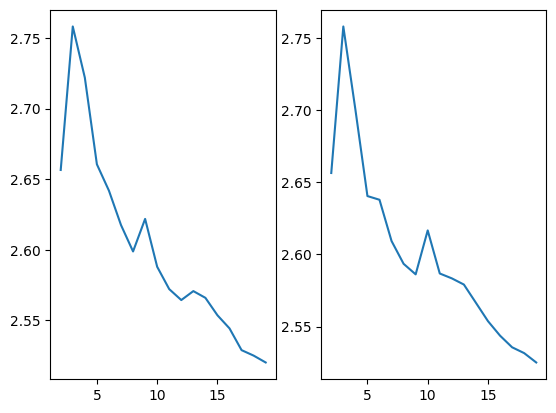

In [22]:
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import v_measure_score
import numpy as np
import matplotlib.pyplot as plt

K = np.arange(2, 20)
v_score_plus = np.zeros((K.size))
v_score_random = np.zeros((K.size))
for k in K:
    kmeans_plus = KMeans(n_clusters = k, random_state=420, n_init=1, init = 'k-means++').fit(X)
    kmeans_random = KMeans(n_clusters = k, random_state=420, n_init=1, init = 'random').fit(X)
    v_score_plus[k-2] = v_measure_score(labels_true = y, labels_pred = kmeans_plus.labels_)
    v_score_random[k-2] = v_measure_score(labels_true = y, labels_pred = kmeans_random.labels_)

best_k = np.argmax(v_score_plus)+2
fig, axs = plt.subplots(1, 2)
axs[0].plot(K, v_score_plus+2)
axs[1].plot(K, v_score_random+2)

<BarContainer object of 2 artists>

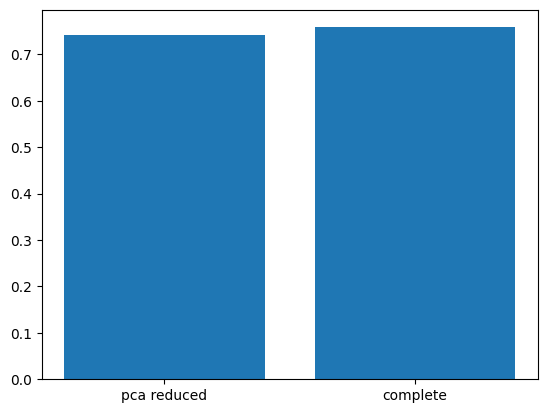

In [33]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)

X_reduced = pca.transform(X)

kmeans_reduced = KMeans(n_clusters = best_k, n_init = 10, random_state=420)
kmeans_reduced.fit(X_reduced)
v_score_reduced = v_measure_score(y, kmeans_reduced.labels_)

plt.bar(['pca reduced', 'complete'],[v_score_reduced, v_score_plus[best_k-2]])
#plt.xticks(bars =  ['pca reduced', 'complete'])


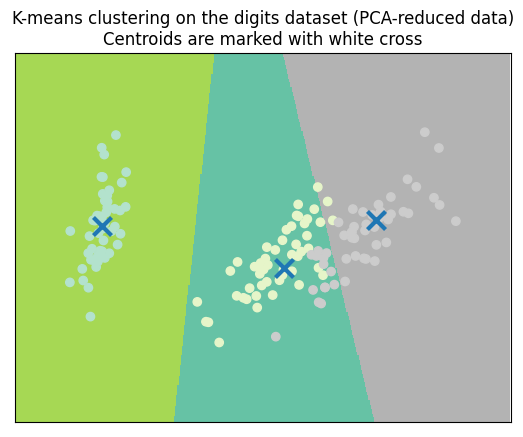

In [12]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

kmeans_model = KMeans(n_clusters=3, random_state=420, n_init=1)
reduced_data = PCA(n_components=2).fit_transform(iris.data)
kmeans_model.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans_model.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
   Z,
   interpolation="nearest",
   extent=(xx.min(), xx.max(), yy.min(), yy.max()),
   cmap='Set2',
   aspect="auto",
   origin="lower",
)

plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=iris.target, cmap='Pastel2')
# Plot the centroids as a white X
centroids = kmeans_model.cluster_centers_

plt.scatter(
   centroids[:, 0],
   centroids[:, 1],
   marker="x",
   s=169,
   linewidths=3,
   zorder=10,
)
plt.title(
   "K-means clustering on the digits dataset (PCA-reduced data)\n"
   "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()



# GMM

In [ ]:
gm = GaussianMixture(n_components=2, random_state=0).fit(X)


Automatically created module for IPython interactive environment


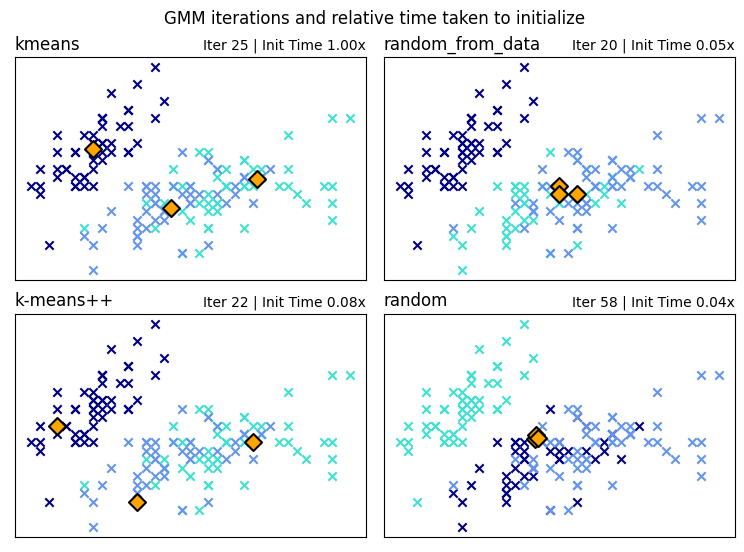

In [34]:
# Author: Gordon Walsh <gordon.p.walsh@gmail.com>
# Data generation code from Jake Vanderplas <vanderplas@astro.washington.edu>

import matplotlib.pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.utils.extmath import row_norms
from sklearn.datasets._samples_generator import make_blobs
from timeit import default_timer as timer

print(__doc__)

# Generate some data

y_true = y

n_components = 3
x_squared_norms = row_norms(X, squared=True)


def get_initial_means(X, init_params, r):
    # Run a GaussianMixture with max_iter=0 to output the initalization means
    gmm = GaussianMixture(
        n_components=n_components, init_params=init_params, tol=1e-9, max_iter=0, random_state=r
    ).fit(X)
    return gmm.means_


methods = ["kmeans", "random_from_data", "k-means++", "random"]
colors = ["navy", "turquoise", "cornflowerblue", "darkorange"]
times_init = {}
relative_times = {}

plt.figure(figsize=(4 * len(methods) // 2, 6))
plt.subplots_adjust(
    bottom=0.1, top=0.9, hspace=0.15, wspace=0.05, left=0.05, right=0.95
)

for n, method in enumerate(methods):
    r = np.random.RandomState(seed=1234)
    plt.subplot(2, len(methods) // 2, n + 1)

    start = timer()
    ini = get_initial_means(X, method, r)
    end = timer()
    init_time = end - start

    gmm = GaussianMixture(
        n_components=n_components, means_init=ini, tol=1e-9, max_iter=2000, random_state=r
    ).fit(X)

    times_init[method] = init_time
    for i, color in enumerate(colors):
        data = X[gmm.predict(X) == i]
        plt.scatter(data[:, 0], data[:, 1], color=color, marker="x")

    plt.scatter(
        ini[:, 0], ini[:, 1], s=75, marker="D", c="orange", lw=1.5, edgecolors="black"
    )
    relative_times[method] = times_init[method] / times_init[methods[0]]

    plt.xticks(())
    plt.yticks(())
    plt.title(method, loc="left", fontsize=12)
    plt.title(
        "Iter %i | Init Time %.2fx" % (gmm.n_iter_, relative_times[method]),
        loc="right",
        fontsize=10,
    )
plt.suptitle("GMM iterations and relative time taken to initialize")
plt.show()

In [36]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV


def gmm_bic_score(estimator, X):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.bic(X)


param_grid = {
    "n_components": range(1, 7),
    "covariance_type": ["spherical", "tied", "diag", "full"],
}
grid_search = GridSearchCV(
    GaussianMixture(), param_grid=param_grid, scoring=gmm_bic_score
)
grid_search.fit(X)

GridSearchCV(estimator=GaussianMixture(),
             param_grid={'covariance_type': ['spherical', 'tied', 'diag',
                                             'full'],
                         'n_components': range(1, 7)},
             scoring=<function gmm_bic_score at 0x0000019924387640>)

In [37]:
import pandas as pd

df = pd.DataFrame(grid_search.cv_results_)[
    ["param_n_components", "param_covariance_type", "mean_test_score"]
]
df["mean_test_score"] = -df["mean_test_score"]
df = df.rename(
    columns={
        "param_n_components": "Number of components",
        "param_covariance_type": "Type of covariance",
        "mean_test_score": "BIC score",
    }
)
df.sort_values(by="BIC score").head()

,Number of components,Type of covariance,BIC score
8,3,tied,232.781477
7,2,tied,235.422102
19,2,full,237.056870
18,1,full,240.046015
6,1,tied,240.046015


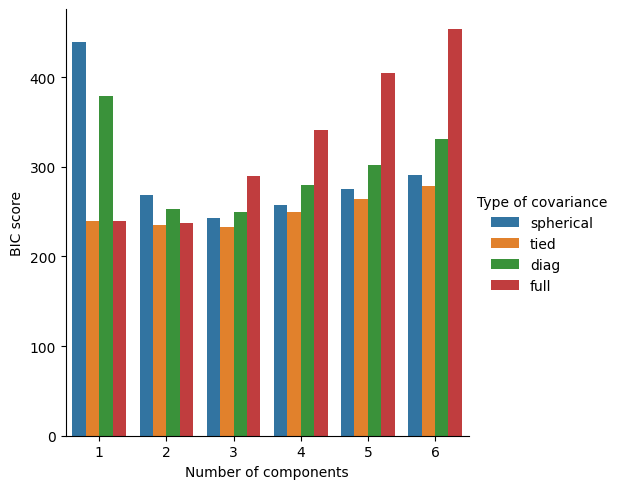

In [40]:
import seaborn as sns

sns.catplot(
    data=df,
    kind="bar",
    x="Number of components",
    y="BIC score",
    hue="Type of covariance",
)
plt.show()